In [2]:
%matplotlib inline

In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [4]:
import utm
from stl import mesh  # install with `pip install numpy-stl`
from mmctools.coupling.terrain import SRTM
import xarray as xr
from scipy.interpolate import RectBivariateSpline, griddata

# Terrain-Resolved Domain Setup
This notebook will generate a surface geometry file to be used by the microscale solver (e.g., SOWFA) to conform the solver domain to the terrain (e.g., with `moveDynamicMesh`).

Notebook written by Eliot Quon, modified by Regis Thedin\
{eliot.quon,regis.thedin}@nrel.gov

Updated Jul 2021. More general changes, leaving this version inside `~/utilities/` for my own use.

## 1. User input

In [5]:
# Output directory (absolute dir)
outdir = '/home/rthedin/stl'

### 1.1 Terrain parameters


First, set the resolution of the data the STL will be created from, and the output resolution.

In [6]:
product = 'SRTM1' # SRTM1 | SRTM3 (30- and 90-m DEM)
ds = 30. # output resolution

The following cell should be modified by the user, following the examples given. The cell contains information about the actual location to be saved.

The `refloc` variable is the location coresponding to (0,0) in SOWFA.

Set the fringe on each side of the domain. This fringe region will used to blend the high-resolution SRTM domain data with either i) low-reosolution WRF (mesoscale) digital elevation model (DEM), or ii) flat.

If `getWRFdata` above is `True`, then blending to mesoscale will occur; otherwise, the domain will be blended to flat. If blending to flat, the user can specify an extra fringe region of completely flat domain (`fringe_flat`). Additionally, if blending to flat, the terrain surface data can be shifted vertically such that the flat region is at $z=0$ by setting `shiftFlatToZero` to `True`.

With respect to the bounding box, it is nice to have the boundaries exactly where the mesh would go because of the blending. For instance, a 5x5 km domain needs to match all the levels of cells: 20, 40, 80, 160 m. Essentially, 5000/160 needs to be an integer number, the same way 5000/80 needs to be as well. However, we only really need to match the coarsest resolution because they are multiple. Finally, an extra fringe of width `ds` (the resolution set above) is added, half on each side. The desired bounding box should go into the `xmin`,`xmax`,`ymin`,`ymax` variables, ignoring the `ds` addition. This extra fringe is to ensure that the STL is slighly larger than the bounding box that will be set on the microscale solver (needed in OpenFOAM to avoid numerical issues).

#### TOTW region

In [6]:
# # For TOTW. Fits both 20/40/80/160 and 30/60/120/240m grids (30m is the resolution from SRTM1)
# refloc = (42.944092, -105.773689, 500) # TOTW turbine 3032051 location
# xmin,xmax = -25000-ds/2, 5240+ds/2
# ymin,ymax = -7000-ds/2,  13160+ds/2
# fringe_flat=100
# shiftFlatToZero=True
# getWRFdata = False
# fringe_s = 2000
# fringe_n = 2000
# fringe_w = 4000
# fringe_e = 2000
# case = f'totw_xm{abs(int(xmin))}to{int(xmax)}_ym{abs(int(ymin))}to{int(ymax)}_blendFlat2N2S2E4W_ff{fringe_flat}'

# # For TOTW. Large 50x50 km bounding box. Fits both 20/40/80/160 and 30/60/120/240m grids
# refloc = (42.790035, -106.1757, 500) # NOT turbine 30320451. Maybe Rimple's (0,0)?
# xmin,xmax = 0-ds/2, 49920+ds/2
# ymin,ymax = 0-ds/2, 49920+ds/2
# fringe_flat=100
# shiftFlatToZero=True
# getWRFdata = False
# fringe_s = 3000
# fringe_n = 3000
# fringe_w = 3000
# fringe_e = 3000
# case = f'totw_xm{abs(int(xmin))}to{int(xmax)}_ym{abs(int(ymin))}to{int(ymax)}_blendFlat3N3S3E3W_ff{fringe_flat}'

# For TOTW region. Small 6x6 km bounding box. Fits 20/40/80/160, but NOT 30/60/120/240m grids
refloc = (42.944092, -105.773689, 500) # TOTW turbine 3032051 location
# xmin,xmax = -3500-ds/2, 2580+ds/2 # for a 6x6km terrain area
# ymin,ymax = -500-ds/2, 5580+ds/2  # for a 6x6km terrain area
xmin,xmax = -5000-ds/2, 2580+ds/2 # for larger terrain so that 135deg winds have room for proper sb and sx calculations
ymin,ymax = -2000-ds/2, 5580+ds/2  # for a 6x6km terrain area
fringe_w = 500
fringe_s = 500
fringe_n = 500
fringe_e = 500
fringe_flat=80 # only use when getWRFdata is False
getWRFdata = False # no WRF data for TOTW
case =  f'totw_xm{abs(int(xmin))}to{int(xmax)}_ym{abs(int(ymin))}to{int(ymax)}_ds{ds}'
caseBlendString = f'0p5N0p5S05E0p5W_ff{fringe_flat}'
saveFig=False

In [ ]:
refloc = (42.944092, -105.773689, 500) # TOTW turbine 3032051 location. My (0,0)
xmin,xmax = -3500, 2580 # for a 6x6km terrain area
ymin,ymax = -500, 5580  # for a 6x6km terrain area

#### WFIP2/Biglow region

In [17]:
# For WFIP2 region. Large region for boundary coupling study, Fits both 20/40/80/160 and 30/60/120/240m grids, as well as 756m low-res WRF-like grids
refloc = (45.638004, -120.642973, 495) # biglow PS12 met mast
xmin,xmax = -15000-ds/2, 15720+ds/2
#ymin,ymax = -5000-ds/2, 14200+ds/2  # for a 30x20km terrain area
ymin,ymax = -15000-ds/2, 13800+ds/2  # for a 30x30km terrain area
fringe_w = 3000
fringe_s = 3000
fringe_n = 3000
fringe_e = 3000
createWRFterrains = True
if createWRFterrains:
    fringe_flat=0;     # do not modify
    getWRFdata = True; # do not modify
    saveFig=True       # do not modify
    caseBlendString = '3N3S3E3W'  # user modifiable
    wrfout = '/projects/mmc/cdraxl/wfip/WFIP2/control/2016112106/wrfout_d02_2016-11-21_07_00_00'
else:
    fringe_flat=80;   # user modifiable
    getWRFdata=False  # do not modify
    saveFig=False     # do not modify
    caseBlendString = f'3N3S3E3W_ff{fringe_flat}'   # user modifiable
case =  f'wfip_xm{abs(int(xmin))}to{int(xmax)}_ym{abs(int(ymin))}to{int(ymax)}_ds{ds}'



#### PA ridge

In [14]:
# For PA ridge from Dave Brande's Nov 12, 2021 email. 6x6 domain
#refloc = (40.54, -77.76, 500) # SW corner from his email. See note below
refloc = (40.543, -77.718, 500)
ds = 10.
xmin,xmax = -3500-ds/2, 2580+ds/2 # for a 6x6km terrain area
ymin,ymax = -500-ds/2, 5580+ds/2  # for a 6x6km terrain area
fringe_w = 500
fringe_s = 500
fringe_n = 500
fringe_e = 500
fringe_flat=80 # only use when getWRFdata is False
getWRFdata = False # no WRF data for TOTW
case =  f'PAridge_xm{abs(int(xmin))}to{int(xmax)}_ym{abs(int(ymin))}to{int(ymax)}_ds{ds}'
caseBlendString = f'0p5N0p5S05E0p5W_ff{fringe_flat}'
saveFig=False

# === Notes ====
# Dave gave me (40.54, -77.76) as the lower-left corner of the box. I do want to keep the extents as x=-3500:2580 m, y=-500:5580 so that
# it matches the TOTW and the precursors that I already have. Using the lat/lon he gave and setting the extents I want, gives me the (0,0)
# at the corner and thus the whole geometry is shifted. I first ran up to the follwoing line using his original lat/lon:
# utm.to_latlon(xref, yref, zone_number=srtm.zone_number, northern=True)
# which using the xref and yref computed, gives us back the (40.54, -77.76) location, as it should.

# Therefore, to have that lower-left corner at this lat/lon but having the domain extents I want (with (0,0) being arbitrarily in the middle,
# I have to use my domain extents to set new references and get the new lat/lon for (0,0)
# utm.to_latlon(xref-(-3500), yref-(-500), zone_number=srtm.zone_number, northern=True)
# Which gives us (40.543, -77.718)

# Towards the end of this notebook, I manually overwrote zero to 280. `zero` is the mean flat terrain to be blended.


In [353]:
# For PA ridge from Dave Brande's Nov 12, 2021 email. Larger 10x10 km.
# The idea of this case is that I will double the cell size and have the same size as the 6x6 10-m resolution case. Domain extents will be longer on East, North
#refloc = (40.54, -77.76, 500) # SW corner from his email. See note below
refloc = (40.543, -77.718, 500)
ds = 30.
xmin,xmax = -3500-ds/2, 2580+ds/2+4000 # for a 10x10km terrain area
ymin,ymax = -500-ds/2, 5580+ds/2+4000  # for a 10x10km terrain area
fringe_w = 1000
fringe_s = 500
fringe_n = 1000
fringe_e = 500
fringe_flat=80 # only use when getWRFdata is False
getWRFdata = False # no WRF data for TOTW
case =  f'PAridge_xm{abs(int(xmin))}to{int(xmax)}_ym{abs(int(ymin))}to{int(ymax)}_ds{ds}'
caseBlendString = f'1N0p5S05E1W_ff{fringe_flat}'
saveFig=False

# === Note ====
# zero/flat has not been overwritten

### 1.2. Print info

In [18]:
extentx = xmax-xmin-ds
extenty = ymax-ymin-ds

# Prints number of cells for each level. I only want integers here, ideally
print(f'Number of cells in each direction for a given cell size\n')
print(f'cell size| {extentx:.1f} m in x      {extenty:.1f} m in y')
print('--------------------------------------------------')
for i in [30,60,120,240,480,960,  20,40,80,160,320,640]:
    print(i,'\t | ',extentx/i,'\t\t  ', extenty/i)
    if i==960: print('--------------------------------------------------')

Number of cells in each direction for a given cell size

cell size| 30720.0 m in x      28800.0 m in y
--------------------------------------------------
30 	 |  1024.0 		   960.0
60 	 |  512.0 		   480.0
120 	 |  256.0 		   240.0
240 	 |  128.0 		   120.0
480 	 |  64.0 		   60.0
960 	 |  32.0 		   30.0
--------------------------------------------------
20 	 |  1536.0 		   1440.0
40 	 |  768.0 		   720.0
80 	 |  384.0 		   360.0
160 	 |  192.0 		   180.0
320 	 |  96.0 		   90.0
640 	 |  48.0 		   45.0


## 2. Create output surface

In [19]:
x1 = np.arange(xmin, xmax+ds, ds)
y1 = np.arange(ymin, ymax+ds, ds)
xsurf,ysurf = np.meshgrid(x1, y1, indexing='ij')

In [20]:
print('The output bounding box is')
print('xmin: ',xsurf[0,0], '\nxmax: ',xsurf[-1,-1])
print('ymin: ',ysurf[0,0], '\nymax: ',ysurf[-1,-1])

The output bounding box is
xmin:  -15015.0 
xmax:  15735.0
ymin:  -15015.0 
ymax:  13815.0


## 3. Get the high-resolution terrain

In [21]:
# Terrain region to clip from the digital elevation model (DEM)
srtm_bounds = west, south, east, north = (refloc[1]-0.5, refloc[0]-0.4, refloc[1]+0.6, refloc[0]+0.4)
srtm_bounds = west, south, east, north = (refloc[1]-0.2, refloc[0]-0.2, refloc[1]+0.2, refloc[0]+0.2)


# this will be downloaded:
srtm_output=f'{outdir}/{case}.tif' # need absolute path for GDAL

In [22]:
srtm = SRTM(srtm_bounds, fpath=srtm_output, product=product)
srtm.download()

<class 'subprocess.CalledProcessError'>
Command 'make -C /home/rthedin/.cache/elevation/SRTM1 clip OUTPUT="/home/rthedin/stl/wfip_xm15015to15735_ym15015to13815_ds30.0.tif" PROJWIN="-120.892973 45.888004 -120.392973 45.388004" RUN_ID="f1c10af4c9e94c83b664374dd2673433"' returned non-zero exit status 2.

Note: Have elevation and gdal been installed properly?


In [23]:
# original SRTM terrain stored as 'z'
x,y,z = srtm.to_terrain()

Output grid at ds= 30.0


RasterioIOError: Read or write failed. /home/rthedin/stl/wfip_xm15015to15735_ym15015to13815_ds30.0.tif, band 1: IReadBlock failed at X offset 3, Y offset 5: TIFFReadEncodedTile() failed.

In [ ]:
# get reference location to use as origin
xref,yref,_,_ = utm.from_latlon(*refloc[:2], force_zone_number=srtm.zone_number)

In [ ]:
fig,ax = plt.subplots(figsize=(9,6))
cm = ax.pcolormesh(x-xref, y-yref, z, shading='auto', cmap='terrain')#,vmin=1500,vmax=2500)
cb = fig.colorbar(cm,ax=ax)
cb.set_label('elevation [m]',fontsize='x-large')
ax.tick_params(labelsize='large')
ax.set_xlabel('easting [m]'); ax.set_ylabel('northing [m]')
ax.set_title(f'{product} DEM projection')
ax.axis('scaled')

# bounding box for microscale region
les = Rectangle((xmin,ymin), xmax-xmin, ymax-ymin, edgecolor='r', lw=3, facecolor='0.5', alpha=0.5)
ax.add_patch(les)
plt.show()

### 3.1 Downscale to output grid

In [ ]:
interpfun = RectBivariateSpline(x[:,0]-xref, y[0,:]-yref, z)

In [ ]:
# resampled SRTM data stored in 'zsrtm'
zsrtm = interpfun(x1,y1,grid=True)

## 4. Get the low-resolution terrain from the mesoscale
This part is only relevant if the user chose to blen the high-resolution SRTM terrain data with WRF

In [ ]:
# Open the dataset
if getWRFdata is True:
    if os.path.isfile(wrfout) is True:
        wrf = xr.open_dataset(wrfout)
        wrf['HGT']
    else:
        print('WRF input does not exist')
        sys.exit(1)

In [ ]:
if getWRFdata is True:
    # wrf fields
    hgt = wrf['HGT'][0,:,:]
    xlat = wrf.coords['XLAT'][0,:,:]
    xlon = wrf.coords['XLONG'][0,:,:]

In [ ]:
#xxx, yyy = srtm.to_xy(xlat.values.ravel(), xlon.values.ravel(), xref=refloc[0], yref=refloc[1])
#plt.plot(xxx,yyy,'o')

In [ ]:
if getWRFdata is True:
    output_lat, output_lon = srtm.to_latlon(xsurf.ravel()+xref, ysurf.ravel()+yref)

In [ ]:
if getWRFdata is True:
    # interpolate to wrf surface elevation based on lat/lon (stored as 'zwrf')
    xi = np.stack((output_lat.ravel(),output_lon.ravel()),axis=-1)
    points = np.stack((xlat.values.ravel(),xlon.values.ravel()),axis=-1)
    values = hgt.values.ravel()
    zi = griddata(points,values,xi)
    zwrf = zi.reshape(xsurf.shape)

## 5. Blend fringe definitions

In [ ]:
# check distance from west boundary
blend_w = np.ones(xsurf.shape)
if fringe_w > 0:
    blend_w = np.minimum(np.maximum((xsurf-xmin-fringe_flat)/fringe_w, 0), 1)

In [ ]:
# check distance from east boundary
blend_e = np.ones(xsurf.shape)
if fringe_e > 0:
    blend_e = np.minimum(np.maximum((xmax-xsurf-fringe_flat)/fringe_e, 0), 1)

In [ ]:
# check distance from south boundary
blend_s = np.ones(xsurf.shape)
if fringe_s > 0:
    blend_s = np.minimum(np.maximum((ysurf-ymin-fringe_flat)/fringe_s, 0), 1)

In [ ]:
# check distance from north boundary
blend_n = np.ones(xsurf.shape)
if fringe_n > 0:
    blend_n = np.minimum(np.maximum((ymax-ysurf-fringe_flat)/fringe_n, 0), 1)

In [ ]:
# combine blending functions
blend = blend_w * blend_e * blend_s * blend_n

In [ ]:
fig,ax = plt.subplots(figsize=(9,4.5))
cm = ax.pcolormesh(xsurf, ysurf, blend, shading='auto', cmap='magma')
cb = fig.colorbar(cm,ax=ax)
ax.tick_params(labelsize='large')
ax.set_xlabel('easting [m]')
ax.set_ylabel('northing [m]')
ax.set_title('blending function')
ax.axis('scaled')
plt.show()

### Blending and shift to mean
The shifting amount in all cases will be `zsrtm.mean()`

In [14]:
# Get amount for all surfaces to be shifted
zero = zsrtm.mean()

NameError: name 'zsrtm' is not defined

In [15]:
#zero=280
# for the PA ridge case

In [42]:
# create flat surface to be blended
zflat = np.full(zsrtm.shape, zero)

In [43]:
# now, blend the high/low resolution elevations
zblendflat = blend*zsrtm + (1-blend)*zflat
zblendflatshift = zblendflat - zero

if getWRFdata is True:
    zblendwrf = blend*zsrtm + (1-blend)*zwrf
    zblendwrfshift = zblendwrf - zero

In [44]:
# shift non-blended terrains, both WRF and SRTM resolution
zsrtmshift = zsrtm - zero

if getWRFdata is True:
    zwrfshift = zwrf - zero

## Visualize terrains

In [74]:
saveFig=True

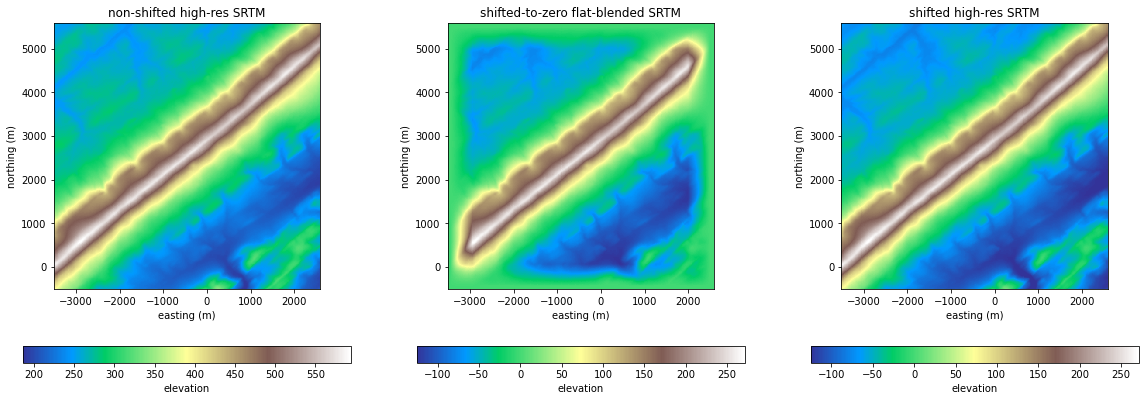

In [45]:
if getWRFdata is True:
    fig,axs = plt.subplots(nrows=2, ncols=3, figsize=(20,15))
    axs=axs.flatten()

    cm = axs[0].pcolormesh(xsurf, ysurf, zsrtm, shading='auto', cmap='terrain')#,vmin=vmin,vmax=vmax)
    cb = fig.colorbar(cm,ax=axs[0], orientation='horizontal', label='elevation')
    axs[0].set_title('high-res SRTM')

    cm = axs[1].pcolormesh(xsurf, ysurf, zsrtmshift, shading='auto', cmap='terrain')
    cb = fig.colorbar(cm,ax=axs[1], orientation='horizontal', label='elevation')
    vmin0 = cb.vmin; vmax0 = cb.vmax
    axs[1].set_title('shifted-to-zero high-res SRTM')

    cm = axs[2].pcolormesh(xsurf, ysurf, zblendflatshift, shading='auto', cmap='terrain',vmin=vmin0,vmax=vmax0)
    cb = fig.colorbar(cm,ax=axs[2], orientation='horizontal', label='elevation')
    vmin = cb.vmin; vmax = cb.vmax
    axs[2].set_title('shifted-to-zero flat-blended SRTM')

    
    
    cm = axs[3].pcolormesh(xsurf, ysurf, zwrf, shading='auto', cmap='terrain')
    cb = fig.colorbar(cm,ax=axs[3], orientation='horizontal', label='elevation')
    vmin = cb.vmin; vmax = cb.vmax
    axs[3].set_title('non-shifted low-res WRF')

    cm = axs[4].pcolormesh(xsurf, ysurf, zwrfshift, shading='auto', cmap='terrain',vmin=vmin0,vmax=vmax0)
    cb = fig.colorbar(cm,ax=axs[4], orientation='horizontal', label='elevation')
    axs[4].set_title('shifted-to-zero low-res WRF')

    cm = axs[5].pcolormesh(xsurf, ysurf, zblendwrf, shading='auto', cmap='terrain',vmin=vmin,vmax=vmax)
    cb = fig.colorbar(cm,ax=axs[5], orientation='horizontal', label='elevation')
    axs[5].set_title('non-shifted WRF-blended high-res SRTM')

else:
    fig,axs = plt.subplots(nrows=1, ncols=3, figsize=(20,7))
    axs=axs.flatten()

    cm = axs[0].pcolormesh(xsurf, ysurf, zsrtm, shading='auto', cmap='terrain')#,vmin=vmin,vmax=vmax)
    cb = fig.colorbar(cm,ax=axs[0], orientation='horizontal', label='elevation')
    vmin = cb.vmin; vmax = cb.vmax
    axs[0].set_title('non-shifted high-res SRTM')

    cm = axs[1].pcolormesh(xsurf, ysurf, zblendflatshift, shading='auto', cmap='terrain')
    cb = fig.colorbar(cm,ax=axs[1], orientation='horizontal', label='elevation')
    vmin = cb.vmin; vmax = cb.vmax
    axs[1].set_title('shifted-to-zero flat-blended SRTM')

    cm = axs[2].pcolormesh(xsurf, ysurf, zsrtmshift, shading='auto', cmap='terrain',vmin=vmin,vmax=vmax)
    cb = fig.colorbar(cm,ax=axs[2], orientation='horizontal', label='elevation')
    axs[2].set_title('shifted high-res SRTM')

        
for ax in axs:
    ax.set_xlabel('easting (m)')
    ax.set_ylabel('northing (m)')
    ax.axis('scaled')

plt.show()

if saveFig: fig.savefig(f'{outdir}/{case}.png',dpi=150,bbox_inches='tight', transparent=False)

In [50]:
plt.rcParams.update({'font.size': 13})

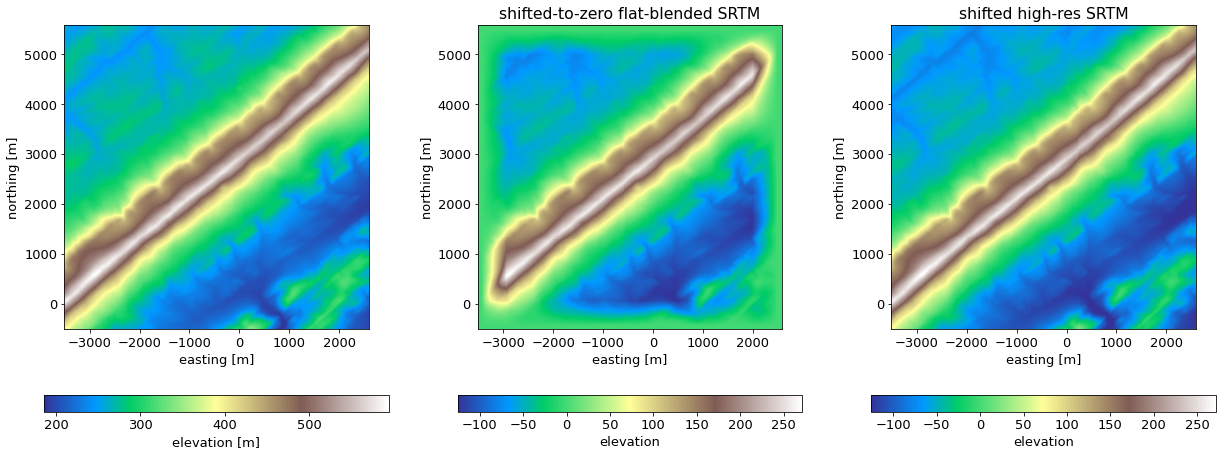

In [52]:
if getWRFdata is True:
    fig,axs = plt.subplots(nrows=2, ncols=3, figsize=(22,17))
    axs=axs.flatten()

    cm = axs[0].pcolormesh(xsurf, ysurf, zsrtm, shading='auto', cmap='terrain')#,vmin=vmin,vmax=vmax)
    cb = fig.colorbar(cm,ax=axs[0], orientation='horizontal', label='elevation')
    axs[0].set_title('high-res SRTM')

    cm = axs[1].pcolormesh(xsurf, ysurf, zsrtmshift, shading='auto', cmap='terrain')
    cb = fig.colorbar(cm,ax=axs[1], orientation='horizontal', label='elevation')
    vmin0 = cb.vmin; vmax0 = cb.vmax
    axs[1].set_title('shifted-to-zero high-res SRTM')

    cm = axs[2].pcolormesh(xsurf, ysurf, zblendflatshift, shading='auto', cmap='terrain',vmin=vmin0,vmax=vmax0)
    cb = fig.colorbar(cm,ax=axs[2], orientation='horizontal', label='elevation')
    vmin = cb.vmin; vmax = cb.vmax
    axs[2].set_title('shifted-to-zero flat-blended SRTM')

    
    
    cm = axs[3].pcolormesh(xsurf, ysurf, zwrf, shading='auto', cmap='terrain')
    cb = fig.colorbar(cm,ax=axs[3], orientation='horizontal', label='elevation')
    vmin = cb.vmin; vmax = cb.vmax
    axs[3].set_title('non-shifted low-res WRF')

    cm = axs[4].pcolormesh(xsurf, ysurf, zwrfshift, shading='auto', cmap='terrain',vmin=vmin0,vmax=vmax0)
    cb = fig.colorbar(cm,ax=axs[4], orientation='horizontal', label='elevation')
    axs[4].set_title('shifted-to-zero low-res WRF')

    cm = axs[5].pcolormesh(xsurf, ysurf, zblendwrf, shading='auto', cmap='terrain',vmin=vmin,vmax=vmax)
    cb = fig.colorbar(cm,ax=axs[5], orientation='horizontal', label='elevation')
    axs[5].set_title('non-shifted WRF-blended high-res SRTM')

else:
    fig,axs = plt.subplots(nrows=1, ncols=3, figsize=(21,8))
    axs=axs.flatten()

    cm = axs[0].pcolormesh(xsurf, ysurf, zsrtm, shading='auto', cmap='terrain')#,vmin=vmin,vmax=vmax)
    cb = fig.colorbar(cm,ax=axs[0], orientation='horizontal', label='elevation [m]')
    vmin = cb.vmin; vmax = cb.vmax
    #axs[0].set_title('non-shifted high-res SRTM')

    cm = axs[1].pcolormesh(xsurf, ysurf, zblendflatshift, shading='auto', cmap='terrain')
    cb = fig.colorbar(cm,ax=axs[1], orientation='horizontal', label='elevation')
    vmin = cb.vmin; vmax = cb.vmax
    axs[1].set_title('shifted-to-zero flat-blended SRTM')

    cm = axs[2].pcolormesh(xsurf, ysurf, zsrtmshift, shading='auto', cmap='terrain',vmin=vmin,vmax=vmax)
    cb = fig.colorbar(cm,ax=axs[2], orientation='horizontal', label='elevation')
    axs[2].set_title('shifted high-res SRTM')

        
for ax in axs:
    ax.set_xlabel('easting [m]')
    ax.set_ylabel('northing [m]')
    ax.axis('scaled')

plt.show()

if saveFig: fig.savefig(f'{outdir}/{case}.png',dpi=150,bbox_inches='tight', transparent=False)

## 6. Write out terrain surface STL

In [76]:
def saveSTL (xsurf, ysurf, z, stlout):
    
    # output 'z' surface
    Npts = np.prod(xsurf.shape)
    stlpoints = np.stack((xsurf.ravel(),
                          ysurf.ravel(),
                          z.ravel()),  # <-- output surface here
                         axis=-1)

    stlindices = np.reshape(np.arange(Npts), xsurf.shape)

    Nx,Ny = xsurf.shape
    Nfaces = (Nx-1)*(Ny-1)*2
    surf = mesh.Mesh(np.zeros(Nfaces, dtype=mesh.Mesh.dtype))

    # manually define triangular faces for this simple quad mesh
    iface = 0 
    for i in range(Nx-1):
        for j in range(Ny-1):
            surf.vectors[iface,0,:] = stlpoints[stlindices[i,j],:]
            surf.vectors[iface,1,:] = stlpoints[stlindices[i+1,j],:]
            surf.vectors[iface,2,:] = stlpoints[stlindices[i+1,j+1],:]
            surf.vectors[iface+1,0,:] = stlpoints[stlindices[i+1,j+1],:]
            surf.vectors[iface+1,1,:] = stlpoints[stlindices[i,j+1],:]
            surf.vectors[iface+1,2,:] = stlpoints[stlindices[i,j],:]
            iface += 2
    assert (iface == Nfaces)

    dpath = os.path.dirname(stlout)
    if (not dpath == '') and (not os.path.isdir(dpath)):
        os.makedirs(dpath)
        print('Created',dpath)

    surf.save(stlout)
    # surf.save(stlout, mode=mesh.stl.ASCII) # if ASCII STL is needed
    print('Saved',stlout)

In [78]:
# Saving the STL files. These are separate because with WRF, there is not flat fringe.
# To generate all cases, run twice: one with WRF and no flat fringe; and another without WRF and with flat fringe

if getWRFdata is True:
    stlout = f'{outdir}/{case}_SRTMblendToWRF_{caseBlendString}_noShift_setBlockMeshzMinTo{round(zero)}.stl'
    z= zblendwrf
    saveSTL(xsurf, ysurf, z, stlout)

    stlout = f'{outdir}/{case}_WRFres_shiftMean.stl'
    z= zwrfshift
    saveSTL(xsurf, ysurf, z, stlout)
    
    stlout = f'{outdir}/{case}_WRFres_noShift_setBlockMeshzMinTo{round(zero)}.stl'
    z= zwrf
    saveSTL(xsurf, ysurf, z, stlout)
else:
    stlout = f'{outdir}/{case}_SRTMblendToFlat_{caseBlendString}_shiftFlat.stl'
    #stlout = f'{outdir}/{case}_SRTMblendToFlat_{caseBlendString}_shiftFlat_zflat280m.stl'
    z= zblendflatshift
    saveSTL(xsurf, ysurf, z, stlout)

    stlout = f'{outdir}/{case}_SRTMres_shiftMean.stl'
    #stlout = f'{outdir}/{case}_SRTMres_shiftzflat280m.stl'
    z= zsrtmshift
    saveSTL(xsurf, ysurf, z, stlout)

Saved /home/rthedin/stl/PAridge_xm3505to2585_ym505to5585_ds10.0_SRTMblendToFlat_0p5N0p5S05E0p5W_ff80_shiftFlat_zflat280m.stl
Saved /home/rthedin/stl/PAridge_xm3505to2585_ym505to5585_ds10.0_SRTMres_shiftzflat280m.stl


In [1]:
xsurf

NameError: name 'xsurf' is not defined